<a href="https://colab.research.google.com/github/inbalh1/ML/blob/main/DL_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.svm import SVC

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

BATCH_SIZE = 64
TRAIN_SIZE = 5000
TEST_SIZE = 1000
DEFAULT_NUM_OF_EPOCHS = 60


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,# set to true for first run - TODO: find elegant solution
    transform=ToTensor(),
)

Using cuda device


100%|██████████| 170498071/170498071 [00:02<00:00, 65740251.01it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# HW part 1 - run svm as baseline

def svm_by_type(kernel , X , y , X_test , y_test):
  clf_SVC = SVC(kernel=kernel , decision_function_shape='ovr')
  clf_SVC.fit(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y)
  # TODO: should report accuracy (in the doc)
  print("train acc: ", clf_SVC.score(X.reshape([TRAIN_SIZE, 3 * 32 * 32]), y))
  print("test acc: ", clf_SVC.score(X_test.reshape([TEST_SIZE, 3 * 32 * 32]), y_test))
 
# This is the main function for this part 
def svm(train_sampler, test_sampler):
  # We load everything to 1 batch
  train_dataloader = DataLoader(training_data, batch_size=TRAIN_SIZE , sampler = train_sampler , num_workers=2)
  test_dataloader = DataLoader(test_data, batch_size=TEST_SIZE, sampler = test_sampler , num_workers=2)

  X , y = next(iter(train_dataloader))
  X_test , y_test = next(iter(test_dataloader))

  # linear SVM:
  svm_by_type('linear' , X , y , X_test , y_test)

  # rbf kernel SVM
  svm_by_type('rbf' , X , y , X_test , y_test)


In [ ]:
# HW part 2 - Feed Forward Neural Network

# TODO: should choose parameters here
config = {
    "step_size": [5e-4, 7e-4,  1e-3, 1e-2],
    "momentum": [0.45, 0.5, 0.55, 0.7, 0.8],
    "deviation": [1, 1.5, 2, 2.25, 2.5,  3]
}

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def init_weights_wrapper(deviation):
  def init_weights(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight , std=deviation)
      #torch.nn.init.normal_(m.bias , std=deviation)
      m.bias.data.fill_(0)
  return init_weights

class GridSearch():
  def __init__(self):
    self.best_params = {}
    self.best_acc = 0

  def update_params(self, step_size, momentum, deviation):
    self.best_params['step_size'] = step_size
    self.best_params['momentum'] = momentum
    self.best_params['deviation'] = deviation

  def run(self, train_dataloader, test_dataloader, config, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
    for step_size in config["step_size"]:
      for momentum in config["momentum"]:
        for deviation in config["deviation"]:
          model = NeuralNetwork().to(device)
          model.apply(init_weights_wrapper(deviation))

          loss_fn = nn.CrossEntropyLoss()
          optimizer = torch.optim.SGD(model.parameters(), lr=step_size , momentum=momentum)
          # TODO: should we check train acc or test acc (now we're checking the train)!!!!
          # TODO2 : if we ignore the test(like now) - better not to run it
          train_accuracy, _ , __, ___ = train_and_test(train_dataloader, test_dataloader, model,
                                                       loss_fn, optimizer,
                                                       num_of_test_batches=1, num_of_epochs=num_of_epochs, verbose=verbose)
          accuracy = train_accuracy[-1] # Take last accuracy
          if accuracy > self.best_acc:
            self.update_params(step_size, momentum, deviation)
            self.best_acc = accuracy

# Train the model for a single epoch
# Returns accuracy and loss
def epoch_train(dataloader, model, loss_fn, optimizer, num_of_batches=-1, verbose=False):
    model.train()

    # Calculate the size of data we run on
    if num_of_batches > 0:
      size = num_of_batches * BATCH_SIZE
    else:
      size = TRAIN_SIZE

    # loss and accuracy of the entire epoch
    epoch_loss, epoch_accuracy  = 0, 0
    for batch, (X, y) in enumerate(dataloader):
      # Dont run more than num_of_batches batches (-1 means to run all)
      if batch == num_of_batches:
        break
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (batch % 100 == 0) and verbose:
          current = (batch + 1) * len(X)
          print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
      epoch_loss += loss.item()
      epoch_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate the total loss and accuracy
    if num_of_batches > 0:
      loss = epoch_loss / num_of_batches
    else:
      loss = epoch_loss / len(dataloader)
    accuracy = epoch_accuracy / size
    return accuracy, loss

def test(dataloader, model, loss_fn, num_of_batches=-1, verbose=False):
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
          # Dont run more than num_of_batches batches (-1 means to run all)
          if batch == num_of_batches:
            break
          X, y = X.to(device), y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate the total loss and accuracy
    if num_of_batches > 0:
      size = num_of_batches * BATCH_SIZE
      test_loss = test_loss / num_of_batches
    else:
      size = TEST_SIZE #len(dataloader.dataset)
      test_loss = test_loss / len(dataloader)
    accuracy = correct / size
    if verbose:
      print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy, test_loss

# Run train and test for num_of_epochs
# TODO: what should be default for num_of_test_batches?
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer,
                   num_of_train_batches=-1, num_of_test_batches=-1, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
    all_loss, all_accuracy, all_test_accuracy, all_test_loss = [], [], [], []
    for i in range(num_of_epochs):
      epoch_accuracy, epoch_loss = epoch_train(train_dataloader, model, loss_fn,
                                             optimizer, num_of_batches=num_of_train_batches, verbose=verbose)
      test_accuracy, test_loss = test(test_dataloader, model, loss_fn, num_of_batches=num_of_test_batches, verbose=verbose)
      all_test_accuracy.append(test_accuracy)
      all_test_loss.append(test_loss)
      all_accuracy.append(epoch_accuracy)
      all_loss.append(epoch_loss)
    return all_accuracy, all_loss, all_test_accuracy, all_test_loss

# Plot train and test accuracy on the same graph,
# and train and test losses on the same graph.
def plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, suptitle):
  epochs = [(x + 1) for x in range(num_of_epochs)]
  fig, axs = plt.subplots(2)
  fig.suptitle(suptitle)
  fig.tight_layout()#pad=3)
  # Plot
  #axs[0].set_title("Accuracy as func of epochs")
  axs[0].plot(epochs, train_accuracy)
  axs[0].plot(epochs, test_accuracy)
  axs[0].set(xlabel='epochs', ylabel='accuracy')
  axs[0].grid()
  axs[0].legend(["train", "test"], loc="best")

  #axs[1].set_title("Loss as func of epochs")
  axs[1].plot(epochs, train_loss)
  axs[1].plot(epochs, test_loss)
  axs[1].set(xlabel='epochs', ylabel='loss')
  axs[1].grid()
  axs[1].legend(["train", "test"], loc="best")

  # TODO: should plt.show be here?
  plt.show()

def pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss):
  # Print the results at the end of optimization
  print(f"Train Error: \n Accuracy: {(100*train_accuracy[-1]):>0.1f}%, Avg loss: {train_loss[-1]:>8f} \n")
  print(f"Test Error: \n Accuracy: {(100*test_accuracy[-1]):>0.1f}%, Avg loss: {test_loss[-1]:>8f} \n")

# Part 2.1
# Run the baseline of this part (train and test) and plot the results
# config is a dict of the parameters to run the network with
def run_baseline(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  # Train the network with the best parameters and then test it
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  # TODO: can we delete this print?
  for name, param in model.named_parameters():
          print(name , param)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.1 baseline")

  print("Baseline results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)


In [ ]:
# Part 2.2
def change_optimization(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  # TODO: should we change the momentum (betas) in here?
  optimizer = torch.optim.Adam(model.parameters(), lr=config["step_size"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.2 optimization")
  
  print("Adam optimization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

In [ ]:
# Part 2.3

def init_weights_with_xavier(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.xavier_uniform_(m.bias)
        m.bias.data.fill_(0)

def change_initialization(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetwork().to(device)
  model.apply(init_weights_with_xavier)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.3 initialization")
  
  print("Xavier initialization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

In [ ]:
# Part 2.4

class DropoutNeuralNetwork(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(256, 10)
            #nn.Dropout(dropout)

        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


def regularization(config, train_dataloader, test_dataloader, dropout=0.05, weight_decay=0.1, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = DropoutNeuralNetwork(dropout).to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"] , weight_decay=weight_decay)
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.4 regularization")

  print("Regularization results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)
  print("Weight decay is: ", weight_decay, " dropout is: ", dropout)

In [15]:
# Part 2.5
from sklearn.decomposition import PCA
from torchvision.transforms import Compose

class pcaTransform():
    def __init__(self, pca):
        self.pca = pca
    def __call__(self, sample):
        print("sample size: ", sample.shape)
        image, landmarks = sample['image'], sample['landmarks']
        # TODO: might need to flatten in here
        img = self.pca.transform(image)
        return {'image': img, 'landmarks': landmarks}  
  
def get_data_loader():
  pca = PCA()
  pca.fit(all_train)
  t = pcaTransform(pca)
  composed = Compose([ToTensor(), t])

  training_data = datasets.CIFAR10(
      root="data_preprocess2",
      train=True,
      download=True, # set to true for first run - TODO: find elegant solution
      transform=t,
  )

  # Download test data from open datasets.
  test_data = datasets.CIFAR10(
      root="data_preprocess2",
      train=False,
      download=True,# set to true for first run - TODO: find elegant solution
      transform=t,
  )

  train_sampler = torch.utils.data.RandomSampler(training_data, replacement=True, num_samples=TRAIN_SIZE, generator=None)
  test_sampler = torch.utils.data.RandomSampler(test_data, replacement=True, num_samples=TEST_SIZE, generator=None)

  train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=train_sampler , num_workers = 2)
  test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, sampler=test_sampler , num_workers = 2)
  return train_dataloader, test_dataloader


def add_preprocessing(config, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  train_dataloader, test_dataloader = get_data_loader()
  model = NeuralNetwork().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.5 preprocessing")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)


In [38]:

  
#torch.cat([x[0] for x in training_data]).shape
# This is the right one!!!!!!!!!!!!!!

class NeuralNetworkWithPreprocess(nn.Module):
    def __init__(self, pca):
        super().__init__()
        self.pca = pca
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            #nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def whitening(self, x):
        x_ = self.flatten(x)
        x_ = self.pca.transform(torch.Tensor.cpu(x_))
        x = (torch.tensor(x_)).to(device).to(torch.float32)
        return x

    def forward(self, x):
        # Apply preprocessing        
        x = self.whitening(x)
        # Apply the network
        logits = self.linear_relu_stack(x)
        return logits


def get_pca(train_sampler):
  train_dataloader = DataLoader(training_data, batch_size=TRAIN_SIZE, sampler=train_sampler , num_workers = 2)
  pca = PCA(whiten=True, n_components=64) # TODO: not sure about n_comp
  x, y = next(iter(train_dataloader))
  x = x.reshape((TRAIN_SIZE, -1))
  pca.fit(x)
  return pca

def add_preprocessing(config, train_sampler, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  pca = get_pca(train_sampler)
  model = NeuralNetworkWithPreprocess(pca).to(device)
  model.apply(init_weights_wrapper(config["deviation"]))
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.5 preprocessing")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)


In [ ]:
# Part 2.5

from sklearn.decomposition import PCA

class NeuralNetworkWithPreprocess1(nn.Module):
    def __init__(self):
        super().__init__()
        self.pca = PCA(whiten=True)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            #nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def whitening(self, x, is_test):
        x_ = self.flatten(x)
        """
        origin_size = x_.shape[0]
        if origin_size != BATCH_SIZE:
          pad_size = (0, 0, 0, BATCH_SIZE - origin_size)
          x_ = torch.nn.functional.pad(x_, pad_size, "constant", 0)
        """
        if is_test:
          x_ = self.pca.transform(torch.Tensor.cpu(x_))
        else:
          x_ = self.pca.fit_transform(torch.Tensor.cpu(x_))
        x = (torch.tensor(x_)).to(device).to(torch.float32)
        return x

    def forward(self, x, is_test=False):
        #origin_size = x.shape[0]
        # Apply preprocessing        
        x = self.whitening(x, is_test)
        # Apply the network
        #x = self.flatten(x)
        if (x.shape[1] < BATCH_SIZE):
          pad_size = (0, BATCH_SIZE - x.shape[1], 0, 0)
          x = torch.nn.functional.pad(x, pad_size, "constant", 0)
        logits = self.linear_relu_stack(x)
        #return logits[:origin_size, :]
        return logits

def add_preprocessing1(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetworkWithPreprocess1().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss, "2.5 preprocessing")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

In [ ]:
# Part 2.5

from sklearn.decomposition import PCA

class NeuralNetworkWithPreprocess2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pca = PCA(whiten=True, n_components=64)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            #nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def whitening(self, x, is_test):
        x_ = self.flatten(x)
        origin_size = x_.shape[0]
        if origin_size != BATCH_SIZE:
          pad_size = (0, 0, 0, BATCH_SIZE - origin_size)
          x_ = torch.nn.functional.pad(x_, pad_size, "constant", 0)
        if is_test:
          x_ = self.pca.transform(torch.Tensor.cpu(x_))
        else:
          x_ = self.pca.fit_transform(torch.Tensor.cpu(x_))
        x = (torch.tensor(x_)).to(device).to(torch.float32)
        return x

    def forward(self, x, is_test=False):
        origin_size = x.shape[0]
        # Apply preprocessing        
        x = self.whitening(x, is_test)
        # Apply the network
        #x = self.flatten(x)
        """
        if (x.shape[1] < BATCH_SIZE):
          pad_size = (0, BATCH_SIZE - x.shape[1], 0, 0)
          x = torch.nn.functional.pad(x, pad_size, "constant", 0)
        """
        logits = self.linear_relu_stack(x)
        return logits[:origin_size, :]
        #return logits

def add_preprocessing2(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetworkWithPreprocess2().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy,
              test_loss, "2.5 preprocessing, n_comp=64")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

In [ ]:
# Part 2.5

from sklearn.decomposition import PCA

class NeuralNetworkWithPreprocess3(nn.Module):
    def __init__(self):
        super().__init__()
        self.pca = PCA(whiten=True, n_components=1)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #nn.Linear(BATCH_SIZE, 256),
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def whitening(self, x, is_test):
        x_ = self.flatten(x)
        """
        origin_size = x_.shape[0]
        if origin_size != BATCH_SIZE:
          pad_size = (0, 0, 0, BATCH_SIZE - origin_size)
          x_ = torch.nn.functional.pad(x_, pad_size, "constant", 0)
        """
        if is_test:
          x_ = self.pca.transform(torch.Tensor.cpu(x_))
        else:
          x_ = self.pca.fit_transform(torch.Tensor.cpu(x_))
        x = (torch.tensor(x_)).to(device).to(torch.float32)
        return x

    def forward(self, x, is_test=False):
        #origin_size = x.shape[0]
        # Apply preprocessing        
        x = self.whitening(x, is_test)
        # Apply the network
        #x = self.flatten(x)
        """
        if (x.shape[1] < BATCH_SIZE):
          pad_size = (0, BATCH_SIZE - x.shape[1], 0, 0)
          x = torch.nn.functional.pad(x, pad_size, "constant", 0)
        """
        logits = self.linear_relu_stack(x)
        #return logits[:origin_size, :]
        return logits

def add_preprocessing3(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  model = NeuralNetworkWithPreprocess3().to(device)
  model.apply(init_weights_wrapper(config["deviation"]))

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
  train_accuracy, train_loss, test_accuracy, test_loss =\
          train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  plot_graphs(num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss,
              "2.5 preprocessing, n_comp=1")

  print("Preprocessing results: ")
  pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)

In [ ]:
# Part 2.6

class NeuralNetworkChangingWidth(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, width),
            nn.ReLU(),
            nn.Linear(width, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Create a fig for plotting train and test accuracy and loss
def prepare_fig(suptitle):
  fig, axs = plt.subplots(2)
  fig.suptitle(suptitle)
  fig.tight_layout()#pad=3)
  axs[0].set(xlabel='epochs', ylabel='accuracy')
  axs[0].grid()
  axs[0].legend(["train", "test"], loc="best")
  axs[1].set(xlabel='epochs', ylabel='loss')
  axs[1].grid()
  axs[1].legend(["train", "test"], loc="best")
  return fig, axs  

def plot(axs, num_of_epochs, train_accuracy,
         train_loss, test_accuracy, test_loss):
  # Plot
  epochs = [(x + 1) for x in range(num_of_epochs)]
  axs[0].plot(epochs, train_accuracy)
  axs[0].plot(epochs, test_accuracy)
  axs[1].plot(epochs, train_loss)
  axs[1].plot(epochs, test_loss)
  

def change_width(config, train_dataloader, test_dataloader, num_of_epochs=DEFAULT_NUM_OF_EPOCHS, verbose=False):
  fig, axs = prepare_fig("2.6 width")
  # TODO: shuld fix the legend
  for i in [3, 6, 8]: # TODO: these sizes are just for test, change to real ones
    width = 2 ** i
    model = NeuralNetworkChangingWidth(width).to(device)
    model.apply(init_weights_wrapper(config["deviation"]))

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["step_size"] , momentum=config["momentum"])
    train_accuracy, train_loss, test_accuracy, test_loss =\
            train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, num_of_epochs=num_of_epochs, verbose=verbose)
  
    plot(axs, num_of_epochs, train_accuracy, train_loss, test_accuracy, test_loss)

    print("Changing width results, with width ", width, ":")
    pretty_print_results(train_accuracy, train_loss, test_accuracy, test_loss)
  plt.show()


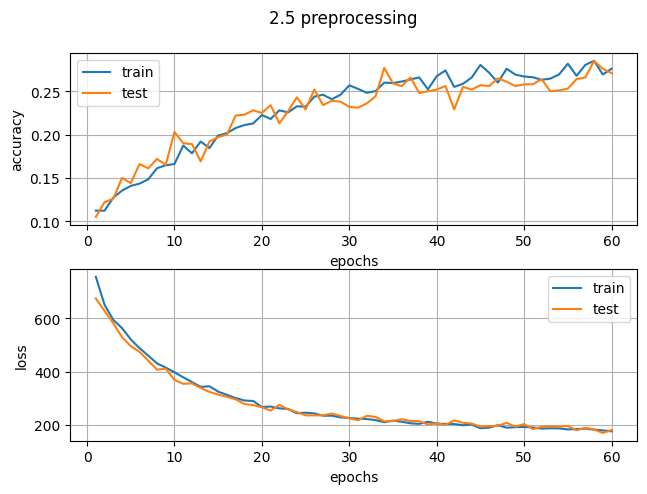

Preprocessing results: 
Train Error: 
 Accuracy: 27.6%, Avg loss: 175.635917 

Test Error: 
 Accuracy: 27.1%, Avg loss: 180.001222 

end


In [39]:
# Run all the parts of the HW we want

should_run_svm = False
should_run_gs = False
should_run_baseline = False
should_run_change_optimization = False
should_run_change_initialization = False
should_run_regularization = False

if __name__ == "__main__":
  # Part 1
  train_sampler = torch.utils.data.RandomSampler(training_data, replacement=True, num_samples=TRAIN_SIZE, generator=None)
  test_sampler = torch.utils.data.RandomSampler(test_data, replacement=True, num_samples=TEST_SIZE, generator=None)

  if should_run_svm:
    svm(train_sampler, test_sampler)

  # Part 2
  # Loaders for NN
  train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=train_sampler , num_workers = 2)
  test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, sampler=test_sampler , num_workers = 2)

  #TODO: run grid search with zero biases
  # Choose best parameters
  best_config = {}
  if should_run_gs: # TODO: run gs to make sure it work
    gs = GridSearch()
    gs.run(train_dataloader, test_dataloader, config, verbose=False)
    best_config["step_size"] = gs.best_params["step_size"]
    best_config["momentum"] = gs.best_params["momentum"]
    best_config["deviation"] =  gs.best_params["deviation"]
  else:
    best_config["step_size"] = 0.001
    best_config["momentum"] = 0.5
    best_config["deviation"] =  2.5
  

  if should_run_baseline:
    run_baseline(best_config, train_dataloader, test_dataloader, verbose=False)
  if should_run_change_optimization:
    change_optimization(best_config, train_dataloader, test_dataloader, verbose=False)
  if should_run_change_initialization:
    change_initialization(best_config, train_dataloader, test_dataloader, verbose=False)
  if should_run_regularization:
    regularization(best_config, train_dataloader, test_dataloader, num_of_epochs=400, verbose=False)
  add_preprocessing(best_config, train_sampler, train_dataloader, test_dataloader, verbose=False)
  #add_preprocessing1(best_config, train_dataloader, test_dataloader, verbose=False)
  #add_preprocessing2(best_config, train_dataloader, test_dataloader, verbose=False)
  #add_preprocessing3(best_config, train_dataloader, test_dataloader, verbose=False)
  #change_width(best_config, train_dataloader, test_dataloader, verbose=False)
  
  # Part 3

  print("end")

In [ ]:
best_config

{'step_size': 0.001, 'momentum': 0.5, 'deviation': 2.5}